In [54]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [55]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [56]:
# inverted index
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [57]:
# Build dataset 

block_size = 3 # context length: number of previous characters to consider for predicting next one

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for c in w + '.':
            i = stoi[c]
            X.append(context)
            Y.append(i)
            # print(''.join(itos[i] for i in context), '--->', itos[i])
            context = context[1:] + [i]
    return torch.tensor(X), torch.tensor(Y)


import random
random.seed(42)
random.shuffle(words)

n1, n2 = int(0.8 * len(words)), int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

print("total dataset size:", len(words))
print(f"data split training {len(Xtr)} dev {len(Xdev)} test {len(Xte)}")    


total dataset size: 32033
data split training 182625 dev 22655 test 22866


In [58]:
# Neural Network

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        # print(f"Linear {x.shape} {self.weight.shape}")
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight, self.bias] if self.bias is not None else [self.weight]
    
class BatchNorm1d:
    def __init__(self, dim, eps=1e-05, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters
        self.gamma = torch.ones(dim) # gain
        self.beta = torch.zeros(dim) # bias
        # running mean and variance
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # forward pass 
        if self.training:
            xmean = x.mean(dim=0)
            xvar = x.var(dim=0)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        # normalize and scale
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        # update running mean and variance
        if self.training:
            with torch.no_grad():
                self.running_mean = xmean * self.momentum + self.running_mean * (1 - self.momentum)
                self.running_var = xvar * self.momentum + self.running_var * (1 - self.momentum)
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
        
        
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
g = torch.Generator().manual_seed(2147483647)
n_embed = 10
n_hidden = 200

C = torch.randn((vocab_size, n_embed), generator=g)
layers = [
    Linear(block_size * n_embed, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(             n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(             n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(             n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(             n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(             n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(             n_hidden, vocab_size),
]

with torch.no_grad():
    # last layer: make less confident
    # layers[-1].weight *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.numel() for p in parameters))
for p in parameters:
    p.requires_grad = True

214097


In [59]:
max_steps = 200000
batch_size = 32
lossi = []
ud = [] # update ratio

# forward pass
for i in range(max_steps):
    # mini batch
    ix = torch.randint(0, len(Xtr), (batch_size,), generator=g)
    Yb, Xb = Ytr[ix], Xtr[ix]

    # get embeddings
    emb = C[Xb] # (:, block_size, embedding_size)
    x = emb.view(-1, block_size * n_embed)
    for layer in layers:
        # print(f"layer {layer.__class__.__name__} {x.shape} ")
        x = layer(x)
    loss = F.cross_entropy(x, Yb)
    # backward pass
    for layer in layers:
        layer.out.retain_grad() # DEBUG: Only for debugging
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad

    # track stats
    if i % 1000 == 0:
        print(f'{i:05d}/{max_steps:05d} loss: {loss.item():.4f}')
    lossi.append(loss.log10().item())  
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])



00000/200000 loss: 3.6954
01000/200000 loss: 2.3515
02000/200000 loss: 2.3414
03000/200000 loss: 2.3834
04000/200000 loss: 2.6667
05000/200000 loss: 2.4008
06000/200000 loss: 2.3418
07000/200000 loss: 1.9832
08000/200000 loss: 2.4656
09000/200000 loss: 2.2947
10000/200000 loss: 2.3380
11000/200000 loss: 2.1920
12000/200000 loss: 2.1516
13000/200000 loss: 2.3528
14000/200000 loss: 2.3502
15000/200000 loss: 2.3132
16000/200000 loss: 2.4412
17000/200000 loss: 2.0116
18000/200000 loss: 2.2600
19000/200000 loss: 1.9703
20000/200000 loss: 2.2741
21000/200000 loss: 2.0476
22000/200000 loss: 1.8382
23000/200000 loss: 2.1717
24000/200000 loss: 2.2928
25000/200000 loss: 2.0109
26000/200000 loss: 1.7619
27000/200000 loss: 2.3651
28000/200000 loss: 1.9625
29000/200000 loss: 2.0739
30000/200000 loss: 2.4760
31000/200000 loss: 2.5202
32000/200000 loss: 2.0989
33000/200000 loss: 2.0719
34000/200000 loss: 2.0819
35000/200000 loss: 1.8808
36000/200000 loss: 2.0672
37000/200000 loss: 2.4938
38000/200000

layer 2 (      Tanh): mean -0.01, std 0.66, saturated: 11.69%
layer 5 (      Tanh): mean -0.01, std 0.70, saturated: 13.25%
layer 8 (      Tanh): mean +0.01, std 0.72, saturated: 13.53%
layer 11 (      Tanh): mean +0.00, std 0.74, saturated: 12.62%
layer 14 (      Tanh): mean -0.00, std 0.75, saturated: 13.95%
layer 17 (      Tanh): mean +0.01, std 0.39, saturated: 1.91%


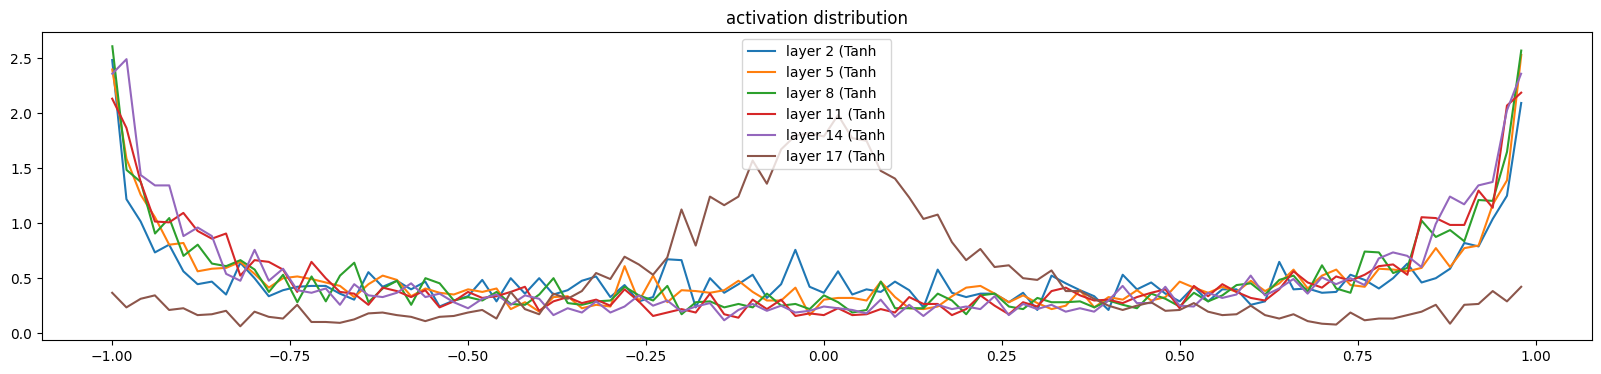

In [60]:
# visualize histograms
# Forward pass activations
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution');

layer 2 (      Tanh): mean +0.000000, std 2.415630e-03
layer 5 (      Tanh): mean -0.000000, std 2.226346e-03
layer 8 (      Tanh): mean -0.000000, std 2.212198e-03
layer 11 (      Tanh): mean +0.000000, std 2.025718e-03
layer 14 (      Tanh): mean +0.000000, std 1.931534e-03
layer 17 (      Tanh): mean -0.000023, std 4.270206e-03


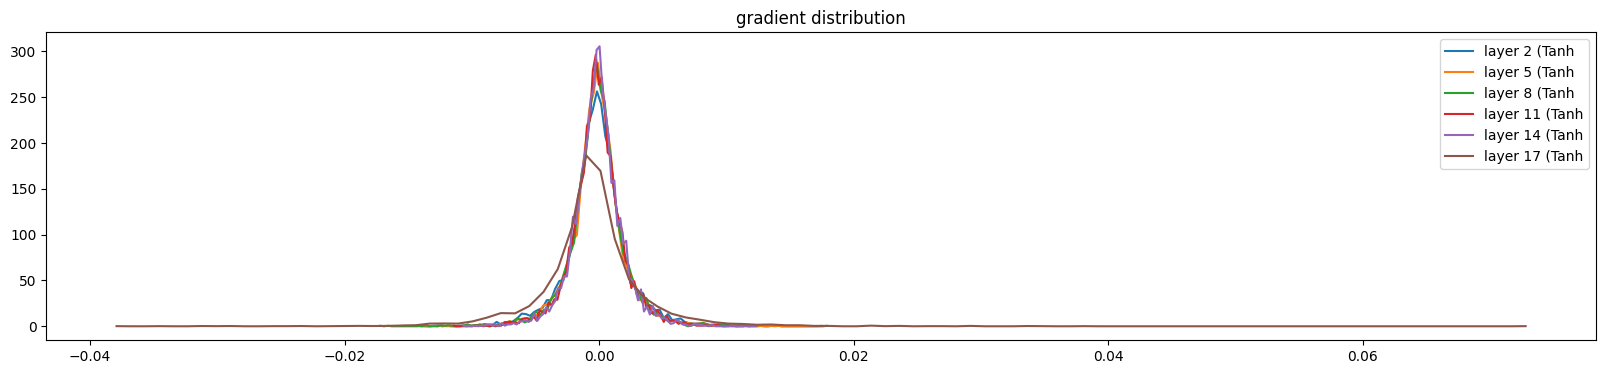

In [61]:
# visualize histograms
# Backward pass gradients of activation function
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution');

weight   (27, 10) | mean +0.000000 | std 1.533715e-02 | grad:data ratio 1.410577e-02
weight  (30, 200) | mean +0.000000 | std 5.815696e-03 | grad:data ratio 1.658133e-02
weight (200, 200) | mean -0.000003 | std 3.235832e-03 | grad:data ratio 2.100545e-02
weight (200, 200) | mean +0.000011 | std 3.362813e-03 | grad:data ratio 2.190656e-02
weight (200, 200) | mean -0.000012 | std 3.246254e-03 | grad:data ratio 2.122148e-02
weight (200, 200) | mean -0.000004 | std 2.899029e-03 | grad:data ratio 1.927762e-02
weight (200, 200) | mean +0.000002 | std 2.411983e-03 | grad:data ratio 1.620703e-02
weight  (200, 27) | mean +0.000000 | std 1.182221e-02 | grad:data ratio 6.664357e-02


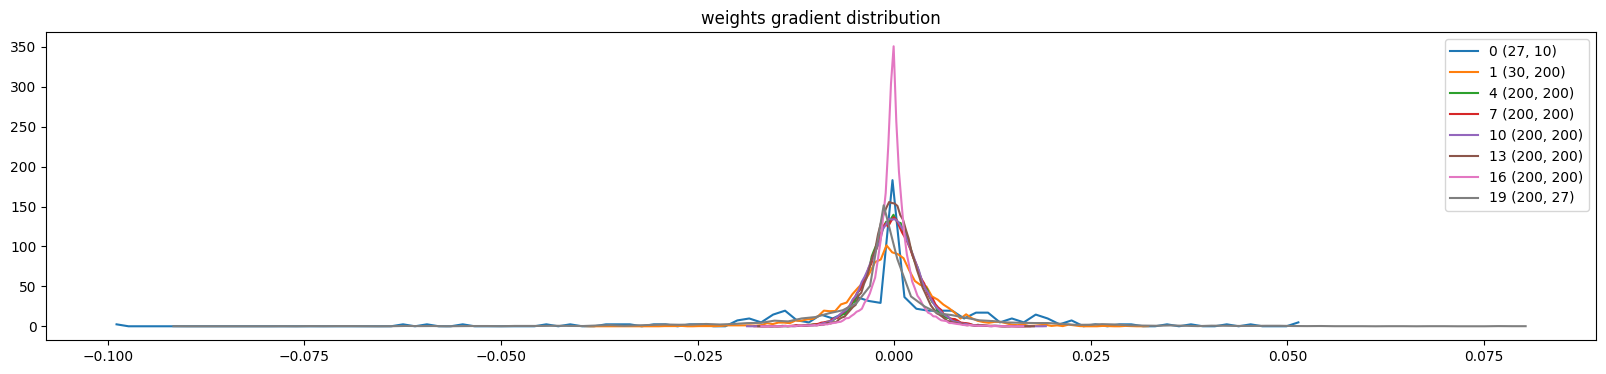

In [62]:
# visualize histograms
# gradient:data ratio
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

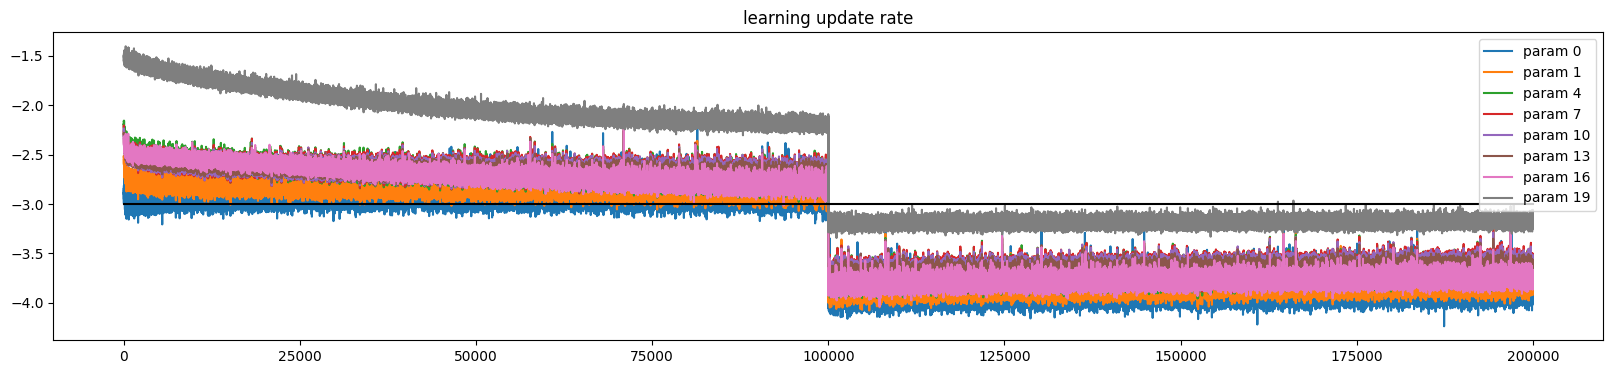

In [63]:
# visulize histograms
# the exponent of the update ratio    
plt.figure(figsize=(20, 4))
legends = []

for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);
plt.title('learning update rate');

In [64]:
#calculate loss
@torch.no_grad() 
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(f"{split:10} loss: ", loss.item())

for layer in layers:
  layer.training = False

split_loss('train')
split_loss('val')

train      loss:  1.9676448106765747
val        loss:  2.0730254650115967


### Model Performance Comparison

**Without Last Layer Damping** (weight * -0.1)
- Train Loss: 1.9676
- Val Loss: 2.0730

**Base Model**
- Train Loss: 1.9664
- Val Loss: 2.0746


In [65]:
g = torch.Generator().manual_seed(2147483647 + 10)# sample from the model 

def sample():
    out = []
    context = [0] * block_size
    name = ''
    while True:
        x = C[torch.tensor(context)].view(1, -1)
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        if ix == 0:
            break
        out.append(ix)
    return ''.join(itos[i] for i in out)

for _ in range(10):
    print(sample())


carmahzamillie
frim
shreetyn
kanys
emmahni
faretahi
kaeli
nellara
chaiivia
leigh
